# Importing the data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

### Create GeoDateFrame from DataFrame

In [2]:
df = pd.read_csv('../data/data_mmda_traffic_spatial_cleaned.csv')

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))
gdf.crs = 'EPSG:4326'
gdf.head()

,Datetime,City,Location,Latitude,Longitude,Direction,Type,Lanes_Blocked,Involved,geometry
0,2018-08-20 7:55 AM,Pasig City,ORTIGAS EMERALD,14.586343,121.061481,EB,ACCIDENT,1.0,TAXI AND MC,POINT (121.06148 14.58634)
1,2018-08-20 9:13 AM,Makati City,EDSA ROCKWELL,14.559818,121.040737,SB,ACCIDENT,1.0,SUV AND L300,POINT (121.04074 14.55982)
2,2018-08-20 10:27 AM,San Juan,ORTIGAS CLUB FILIPINO,14.601846,121.046754,EB,ACCIDENT,1.0,2 CARS,POINT (121.04675 14.60185)
3,2018-08-20 12:33 PM,Quezon City,EDSA ORTIGAS ROBINSONS,14.592515,121.058225,NB,ACCIDENT,1.0,CAR AND BUS,POINT (121.05822 14.59252)
4,2018-08-20 12:39 PM,Mandaluyong,EDSA LIGHT MALL,14.574014,121.048410,NB,MULTIPLE COLLISION,2.0,3 CARS,POINT (121.04841 14.57401)


### Import the spatial data for the boundary of the cities in Metro Manila

In [3]:
boundaries = gpd.read_file('../data/boundary_ncr/cleaned/boundary_ncr.shp')
boundaries.head()

,NAME_2,geometry
0,Kalookan City,"MULTIPOLYGON (((121.02068 14.71426, 121.02071 ..."
1,Las Piñas,"MULTIPOLYGON (((120.97972 14.49306, 120.98000 ..."
2,Makati City,"POLYGON ((121.06578 14.53872, 121.06594 14.538..."
3,Malabon,"POLYGON ((120.95800 14.65938, 120.95796 14.658..."
4,Mandaluyong,"POLYGON ((121.05405 14.57747, 121.05408 14.577..."


# Exploring the data

## Visualizing all accidents

In [4]:
# Perform the spatial join
accident_boundaries = gpd.sjoin(boundaries, gdf, predicate='contains', ).dropna()

# Select only the rows from the boundaries GeoDataFrame
boundaries = boundaries[boundaries.index.isin(accident_boundaries.index)]
boundaries.reset_index(inplace=True, drop=True)

boundaries

,NAME_2,geometry
0,Kalookan City,"MULTIPOLYGON (((121.02068 14.71426, 121.02071 ..."
1,Makati City,"POLYGON ((121.06578 14.53872, 121.06594 14.538..."
2,Malabon,"POLYGON ((120.95800 14.65938, 120.95796 14.658..."
3,Mandaluyong,"POLYGON ((121.05405 14.57747, 121.05408 14.577..."
4,Manila,"POLYGON ((120.99142 14.56218, 120.98849 14.561..."
5,Marikina,"POLYGON ((121.07346 14.61962, 121.07432 14.620..."
6,Navotas,"POLYGON ((120.96163 14.63365, 120.96139 14.633..."
7,Parañaque,"MULTIPOLYGON (((121.00084 14.50921, 121.00104 ..."
8,Pasay City,"POLYGON ((121.00084 14.50921, 121.00070 14.509..."
9,Pasig City,"POLYGON ((121.08282 14.54377, 121.08270 14.543..."


There are only 14 cities within Metro Manila where accidents occur on our dataset.

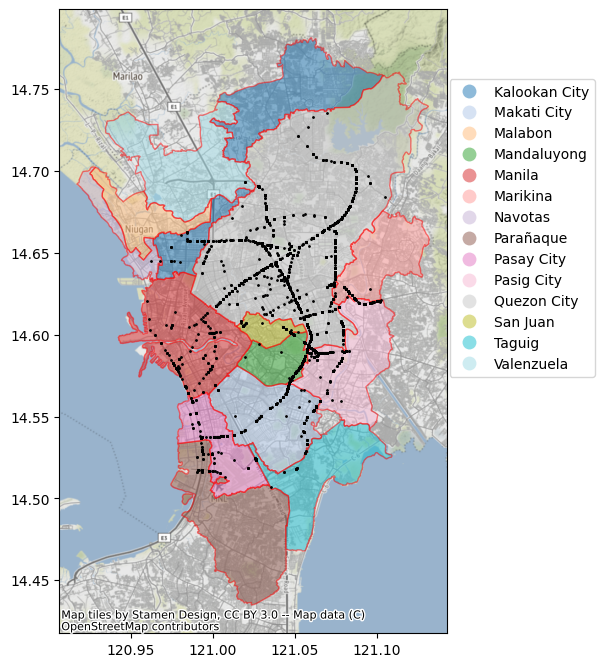

In [5]:
# Plotting the accidents
fig, ax = plt.subplots(figsize=(5, 10))
boundaries.plot(column='NAME_2', edgecolor='red', ax=ax, alpha=0.5,
                legend=True, legend_kwds={"loc": "lower right", "bbox_to_anchor": (1.4, 0.4)}, cmap='tab20')
gdf.plot(ax=ax, markersize=1, color='black')
ctx.add_basemap(ax=ax, crs=gdf.crs)
plt.show()

## Questions

### Q: Which city has the most accidents?

In [6]:
gdf['City'].value_counts()

Quezon City      5918
Mandaluyong      2016
Makati City      1682
Pasig City       1188
Pasay City        277
Manila            214
San Juan           84
Marikina           75
Parañaque          62
Kalookan City      45
Taguig             24
Valenzuela          3
Malabon             3
Navotas             2
Name: City, dtype: int64

### Q: What time of the day do accidents tend to occur?

In [9]:
# Convert Datetime column to datetime
gdf['Datetime'] = pd.to_datetime(gdf['Datetime'])

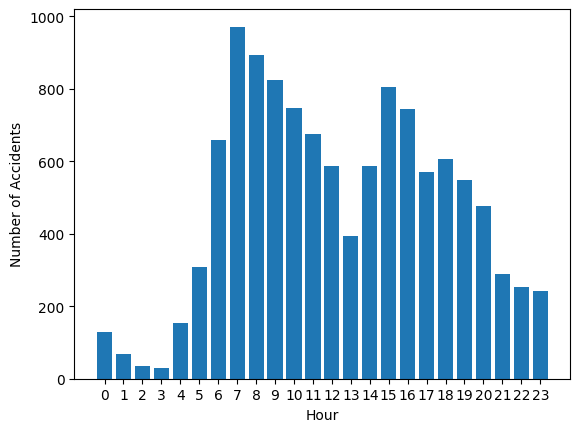

In [68]:
# Plotting the number of accidents per hour
accidents_per_hour = gdf['Datetime'].dt.hour.value_counts()

plt.bar(accidents_per_hour.index, accidents_per_hour.values)
plt.xticks(accidents_per_hour.index)
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.show()

We see that most of the accidents on our dataset occurs at 7 AM in the morning and 3 PM in the afternoon.

### Q: What day of the week do most accidents occur?

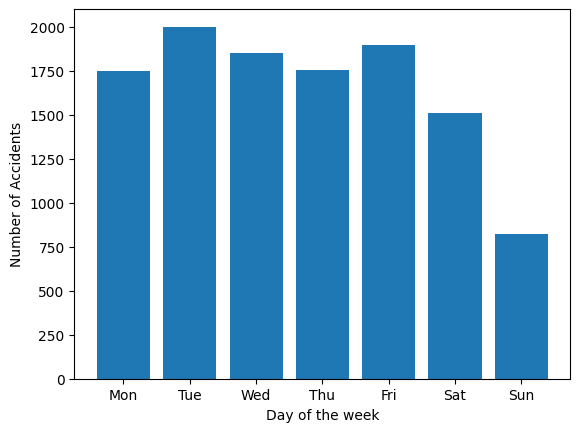

In [73]:
# Plotting the number of accidents per hour
accidents_per_day = gdf['Datetime'].dt.dayofweek.value_counts()

plt.bar(accidents_per_day.index, accidents_per_day.values)
plt.xticks(accidents_per_day.sort_index().index, ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the week')
plt.ylabel('Number of Accidents')
plt.show()

This graph shows that most of the accidents on our dataset occur on the weekdays (when most people go to work) and less on weekends especially Sunday.

### Q: What type of accidents most likely occurs on our dataset?

I've categorized the type of accidents into three:
- Accident (involving at most 2 vehicles)
- Multiple collision (involving 3 or more vehicles)
- Hit and Run

In [75]:
gdf['Type'].value_counts()

ACCIDENT              11026
MULTIPLE COLLISION      528
HIT AND RUN              39
Name: Type, dtype: int64

### Q: What are the number of accidents based on direction?
- NB: North bound
- SB: South bound
- WB: West bound
- EB: East bound

In [80]:
# Counting the number of accidents per direction
gdf['Direction'].value_counts()

NB    4528
SB    4165
EB    1517
WB    1383
Name: Direction, dtype: int64

We see that most accidents occur on the North bound and South bound direction.

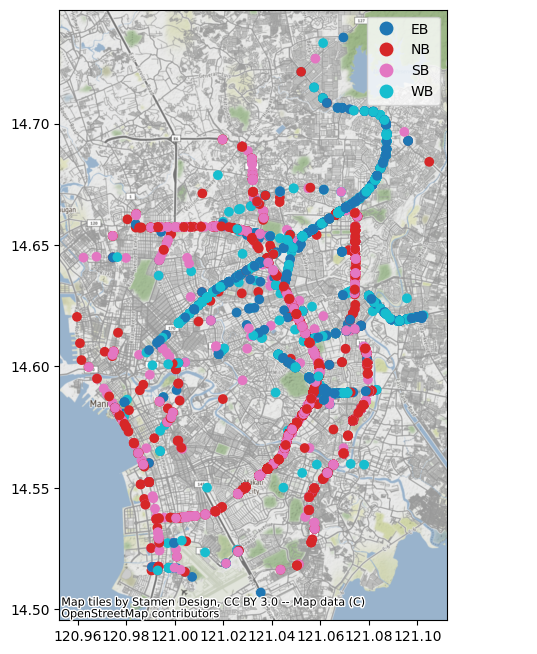

In [79]:
# Plotting the accidents by direction
fig, ax = plt.subplots(figsize=(5, 10))
gdf.plot(column='Direction', ax=ax, legend=True)
ctx.add_basemap(ax=ax, crs=gdf.crs)
plt.show()
